In [2]:
import scanpy as sc
#import pertpy as pt
import numpy as np
import pandas as pd
from sklearn.metrics import r2_score
from tqdm import tqdm
import matplotlib.pyplot as plt

In [2]:
print(pt.__version__)

0.7.0


## Sciplex-3

In [3]:
adata = pt.data.sciplex3_raw()

In [4]:
adata

AnnData object with n_obs × n_vars = 581777 × 58347
    obs: 'cell_type', 'dose', 'dose_character', 'dose_pattern', 'g1s_score', 'g2m_score', 'pathway', 'pathway_level_1', 'pathway_level_2', 'product_dose', 'product_name', 'proliferation_index', 'replicate', 'size_factor', 'target', 'vehicle'
    var: 'id', 'num_cells_expressed-0-0', 'num_cells_expressed-1-0', 'num_cells_expressed-1'

In [5]:
sc.pp.normalize_total(adata)
sc.pp.log1p(adata)

In [6]:
sc.pp.highly_variable_genes(adata, inplace=True, n_top_genes=2000)

In [7]:
adata

AnnData object with n_obs × n_vars = 581777 × 58347
    obs: 'cell_type', 'dose', 'dose_character', 'dose_pattern', 'g1s_score', 'g2m_score', 'pathway', 'pathway_level_1', 'pathway_level_2', 'product_dose', 'product_name', 'proliferation_index', 'replicate', 'size_factor', 'target', 'vehicle'
    var: 'id', 'num_cells_expressed-0-0', 'num_cells_expressed-1-0', 'num_cells_expressed-1', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'log1p', 'hvg'

In [8]:
adata = adata[:,adata.var["highly_variable"]==True]

In [9]:
adata

View of AnnData object with n_obs × n_vars = 581777 × 2000
    obs: 'cell_type', 'dose', 'dose_character', 'dose_pattern', 'g1s_score', 'g2m_score', 'pathway', 'pathway_level_1', 'pathway_level_2', 'product_dose', 'product_name', 'proliferation_index', 'replicate', 'size_factor', 'target', 'vehicle'
    var: 'id', 'num_cells_expressed-0-0', 'num_cells_expressed-1-0', 'num_cells_expressed-1', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'log1p', 'hvg'

In [10]:
adata.obs["perturbation"] = adata.obs["product_name"]
adata.obs["cell_line"] = adata.obs["cell_type"]

/tmp/ipykernel_1021055/3465839703.py:1: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs["perturbation"] = adata.obs["product_name"]


In [91]:
adata_control = adata[adata.obs.perturbation == 'Vehicle']
adata_perturbed = adata[adata.obs.perturbation != 'Vehicle']

In [92]:
adata_control

View of AnnData object with n_obs × n_vars = 13004 × 2000
    obs: 'cell_type', 'dose', 'dose_character', 'dose_pattern', 'g1s_score', 'g2m_score', 'pathway', 'pathway_level_1', 'pathway_level_2', 'product_dose', 'product_name', 'proliferation_index', 'replicate', 'size_factor', 'target', 'vehicle', 'perturbation', 'cell_line'
    var: 'id', 'num_cells_expressed-0-0', 'num_cells_expressed-1-0', 'num_cells_expressed-1', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'log1p', 'hvg'

In [93]:
adata_control.varm["X_train_mean"] = adata_control.X.mean(axis=0).T

/tmp/ipykernel_1021055/3585228133.py:1: ImplicitModificationWarning: Setting element `.varm['X_train_mean']` of view, initializing view as actual.
  adata_control.varm["X_train_mean"] = adata_control.X.mean(axis=0).T


In [94]:
from scipy.sparse import csr_matrix, vstack

train_mean = adata_control.varm["X_train_mean"].T
adata_control.layers["centered_X"] = csr_matrix(adata_control.X.A - train_mean)

In [95]:
sc.pp.pca(adata_control, layer="centered_X", zero_center=False, n_comps=50)

In [96]:
adata_control

AnnData object with n_obs × n_vars = 13004 × 2000
    obs: 'cell_type', 'dose', 'dose_character', 'dose_pattern', 'g1s_score', 'g2m_score', 'pathway', 'pathway_level_1', 'pathway_level_2', 'product_dose', 'product_name', 'proliferation_index', 'replicate', 'size_factor', 'target', 'vehicle', 'perturbation', 'cell_line'
    var: 'id', 'num_cells_expressed-0-0', 'num_cells_expressed-1-0', 'num_cells_expressed-1', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'log1p', 'hvg', 'pca'
    obsm: 'X_pca'
    varm: 'X_train_mean', 'PCs'
    layers: 'centered_X'

In [126]:
decoded_control = np.matmul(adata_control.obsm["X_pca"], adata_control.varm["PCs"].T)

In [127]:
decoded_control.shape

(13004, 2000)

In [128]:
adata_control.varm["X_train_mean"].T.shape

(1, 2000)

In [129]:
decoded_control = decoded_control + adata_control.varm["X_train_mean"].T

In [130]:
decoded_control.shape

(13004, 2000)

In [131]:
adata_control.layers["decoded"] = decoded_control

In [132]:
adata_perturbed.varm["X_train_mean"] = adata_control.varm["X_train_mean"]

In [133]:
adata_perturbed.layers["centered_X"] = csr_matrix(adata_perturbed.X.A - train_mean)


In [134]:
adata_perturbed.obsm["X_pca"] = np.matmul(adata_perturbed.layers["centered_X"].A, adata_control.varm["PCs"])


In [135]:
decoded_perturbed = np.matmul(adata_perturbed.obsm["X_pca"], adata_control.varm["PCs"].T)

In [136]:
decoded_perturbed

array([[ 7.80393835e-02,  3.41828004e-01, -5.10543482e-03, ...,
         0.00000000e+00,  0.00000000e+00, -3.99864773e-04],
       [ 1.01995904e-01,  4.71809951e-02,  2.13708996e-03, ...,
         0.00000000e+00,  0.00000000e+00, -6.94999894e-04],
       [ 4.22458117e-02,  2.38393133e-01, -3.59778556e-03, ...,
         0.00000000e+00,  0.00000000e+00, -5.78315377e-04],
       ...,
       [ 6.69048303e-02, -1.11790441e-01, -3.26662213e-04, ...,
         0.00000000e+00,  0.00000000e+00, -1.32636322e-04],
       [ 2.55742621e-02, -1.63081840e-01, -9.30656761e-03, ...,
         0.00000000e+00,  0.00000000e+00, -9.01088163e-04],
       [-1.19392935e-02, -1.28501196e-01, -9.61455750e-04, ...,
         0.00000000e+00,  0.00000000e+00, -2.39609574e-04]])

In [137]:
decoded_perturbed = decoded_perturbed + adata_perturbed.varm["X_train_mean"].T

In [138]:
decoded_perturbed

matrix([[ 1.48714786e-01,  4.73295033e-01, -3.86351303e-03, ...,
          0.00000000e+00,  0.00000000e+00, -4.27780608e-05],
        [ 1.72671307e-01,  1.78648025e-01,  3.37901175e-03, ...,
          0.00000000e+00,  0.00000000e+00, -3.37913182e-04],
        [ 1.12921215e-01,  3.69860163e-01, -2.35586376e-03, ...,
          0.00000000e+00,  0.00000000e+00, -2.21228665e-04],
        ...,
        [ 1.37580233e-01,  1.96765889e-02,  9.15259583e-04, ...,
          0.00000000e+00,  0.00000000e+00,  2.24450390e-04],
        [ 9.62496650e-02, -3.16148101e-02, -8.06464582e-03, ...,
          0.00000000e+00,  0.00000000e+00, -5.44001451e-04],
        [ 5.87361094e-02,  2.96583391e-03,  2.80466047e-04, ...,
          0.00000000e+00,  0.00000000e+00,  1.17477138e-04]])

In [139]:
decoded_perturbed.shape

(568773, 2000)

In [140]:
adata_perturbed.layers["decoded"] = decoded_perturbed

In [141]:
unique_doses = adata_perturbed.obs["dose"].unique()
unique_perturbations = adata_perturbed.obs["perturbation"].unique()

df = pd.DataFrame(index=unique_doses, columns=unique_perturbations)


In [142]:
df

,Enzastaurin (LY317615),Raltitrexed,Lenalidomide (CC-5013),Divalproex Sodium,MLN8054,Sodium Phenylbutyrate,Celecoxib,Linifanib (ABT-869),Thalidomide,SNS-314,...,Givinostat (ITF2357),SB431542,YM155 (Sepantronium Bromide),Ramelteon,Iniparib (BSI-201),Tucidinostat (Chidamide),PCI-34051,Epothilone A,Thiotepa,PHA-680632
1000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
100.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [183]:
reference_control = np.mean(np.asarray(decoded_control), axis=0)

In [184]:
reference_control.shape

(2000,)

In [185]:
for dose in tqdm(unique_doses):
    for perturbation in tqdm(unique_perturbations):
        adata_temporal = adata_perturbed[(adata_perturbed.obs.dose == dose) & (adata_perturbed.obs.perturbation == perturbation)]
        decoded = adata_temporal.layers["decoded"]
        decoded_mean = np.mean(np.asarray(decoded), axis=0)
        r2score_temporal = r2_score(decoded_mean, reference_control)
        df.loc[dose, perturbation] = r2score_temporal

100%|██████████| 4/4 [00:06<00:00,  1.68s/it]


In [186]:
df

,Enzastaurin (LY317615),Raltitrexed,Lenalidomide (CC-5013),Divalproex Sodium,MLN8054,Sodium Phenylbutyrate,Celecoxib,Linifanib (ABT-869),Thalidomide,SNS-314,...,Givinostat (ITF2357),SB431542,YM155 (Sepantronium Bromide),Ramelteon,Iniparib (BSI-201),Tucidinostat (Chidamide),PCI-34051,Epothilone A,Thiotepa,PHA-680632
1000.0,0.995938,0.963475,0.983394,0.951245,0.960518,0.995127,0.964651,0.995997,0.992278,0.961328,...,0.898484,0.993849,0.631675,0.983447,0.995941,0.955317,0.986858,0.913192,0.984079,0.969389
10.0,0.969037,0.968302,0.998726,0.987578,0.990257,0.994854,0.995995,0.997095,0.99612,0.986088,...,0.978731,0.99022,0.716144,0.994294,0.736835,0.9944,0.994534,0.955435,0.99419,0.983875
100.0,0.994341,0.968841,0.977067,0.995201,0.969407,0.993304,0.994797,0.996768,0.996216,0.980356,...,0.969034,0.996949,0.694541,0.988595,0.99014,0.939727,0.989225,0.905285,0.991989,0.972103
10000.0,0.9609,0.974749,0.992123,0.976793,0.974579,0.990655,0.998321,0.938825,0.993512,0.965974,...,0.728381,0.98878,0.582222,0.991076,0.935654,0.908777,0.981011,0.972235,0.981184,0.94782


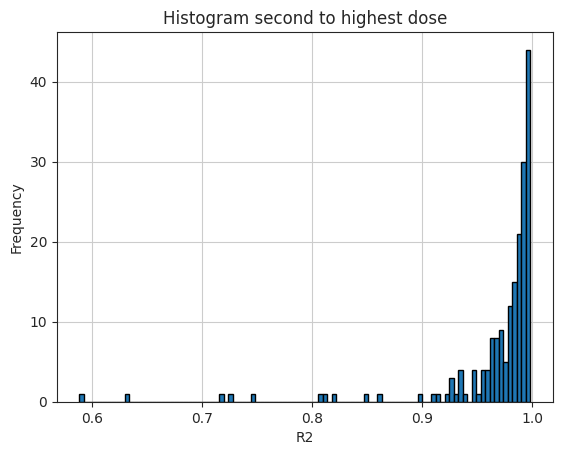

In [194]:
# Plot the histogram
plt.hist(df.iloc[0].values, bins=100, edgecolor='black')  # Adjust the number of bins as needed
plt.title('Histogram second to highest dose')
plt.xlabel('R2')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

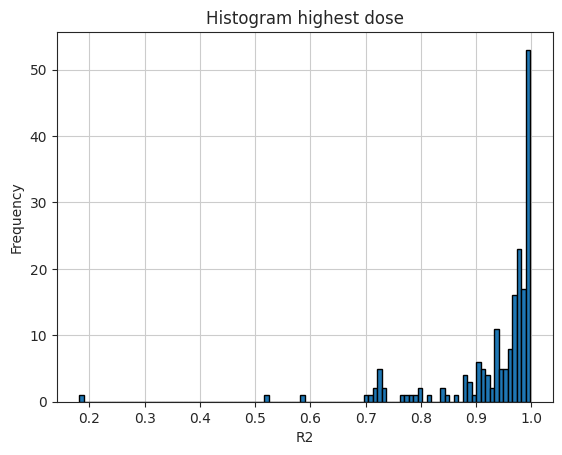

In [196]:
# Plot the histogram
plt.hist(df.iloc[3].values, bins=100, edgecolor='black')  # Adjust the number of bins as needed
plt.title('Histogram highest dose')
plt.xlabel('R2')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

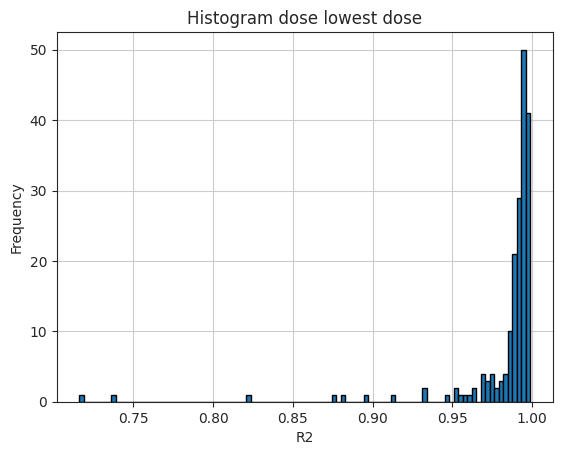

In [197]:
# Plot the histogram
plt.hist(df.iloc[1].values, bins=100, edgecolor='black')  # Adjust the number of bins as needed
plt.title('Histogram dose lowest dose')
plt.xlabel('R2')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

## Combosciplex

In [198]:
adata = pt.data.combosciplex()

/home/icb/alejandro.tejada/miniconda3/envs/pertpy/lib/python3.11/site-packages/rich/live.py:231: UserWarning: 
install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

In [199]:
adata

AnnData object with n_obs × n_vars = 63378 × 27518
    obs: 'sample', 'Size_Factor', 'n.umi', 'RT_well', 'Drug1', 'Drug2', 'Well', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'leiden', 'condition', 'pathway1', 'pathway2', 'split', 'control', 'cell_type'
    var: 'id', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'Drug1_colors', 'Drug2_colors', 'Well_colors', 'condition_colors', 'dendrogram_leiden', 'hvg', 'leiden', 'leiden_colors', 'neighbors', 'pathway1_colors', 'pathway2_colors', 'pathway_colors', 'pca', 'rank_genes_groups', 'split_colors', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'counts'
    obsp: 'connectivities', 'distances'

In [200]:
sc.pp.normalize_total(adata)
sc.pp.log1p(adata)

In [201]:
sc.pp.highly_variable_genes(adata, inplace=True, n_top_genes=2000)

In [202]:
adata

AnnData object with n_obs × n_vars = 63378 × 27518
    obs: 'sample', 'Size_Factor', 'n.umi', 'RT_well', 'Drug1', 'Drug2', 'Well', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'leiden', 'condition', 'pathway1', 'pathway2', 'split', 'control', 'cell_type'
    var: 'id', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'Drug1_colors', 'Drug2_colors', 'Well_colors', 'condition_colors', 'dendrogram_leiden', 'hvg', 'leiden', 'leiden_colors', 'neighbors', 'pathway1_colors', 'pathway2_colors', 'pathway_colors', 'pca', 'rank_genes_groups', 'split_colors', 'umap', 'log1p'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'counts'
    obsp: 'connectivities', 'distances'

In [203]:
adata = adata[:,adata.var["highly_variable"]==True]

In [204]:
adata

View of AnnData object with n_obs × n_vars = 63378 × 2000
    obs: 'sample', 'Size_Factor', 'n.umi', 'RT_well', 'Drug1', 'Drug2', 'Well', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'leiden', 'condition', 'pathway1', 'pathway2', 'split', 'control', 'cell_type'
    var: 'id', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'Drug1_colors', 'Drug2_colors', 'Well_colors', 'condition_colors', 'dendrogram_leiden', 'hvg', 'leiden', 'leiden_colors', 'neighbors', 'pathway1_colors', 'pathway2_colors', 'pathway_colors', 'pca', 'rank_genes_groups', 'split_colors', 'umap', 'log1p'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'counts'
    obsp: 'connectivities', 'distances'

In [209]:
adata.obs["perturbation"] = adata.obs["condition"]
adata.obs["cell_line"] = adata.obs["cell_type"]

/tmp/ipykernel_1021055/41560897.py:1: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs["perturbation"] = adata.obs["condition"]


In [211]:
adata_control = adata[adata.obs.perturbation == 'control+control']
adata_perturbed = adata[adata.obs.perturbation != 'control+control']

In [212]:
adata_control

View of AnnData object with n_obs × n_vars = 1451 × 2000
    obs: 'sample', 'Size_Factor', 'n.umi', 'RT_well', 'Drug1', 'Drug2', 'Well', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'leiden', 'condition', 'pathway1', 'pathway2', 'split', 'control', 'cell_type', 'perturbation', 'cell_line'
    var: 'id', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'Drug1_colors', 'Drug2_colors', 'Well_colors', 'condition_colors', 'dendrogram_leiden', 'hvg', 'leiden', 'leiden_colors', 'neighbors', 'pathway1_colors', 'pathway2_colors', 'pathway_colors', 'pca', 'rank_genes_groups', 'split_colors', 'umap', 'log1p'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'counts'
    obsp: 'connectivities', 'distances'

In [213]:
adata_control.varm["X_train_mean"] = adata_control.X.mean(axis=0).T

/tmp/ipykernel_1021055/3585228133.py:1: ImplicitModificationWarning: Setting element `.varm['X_train_mean']` of view, initializing view as actual.
  adata_control.varm["X_train_mean"] = adata_control.X.mean(axis=0).T


In [214]:
from scipy.sparse import csr_matrix, vstack

train_mean = adata_control.varm["X_train_mean"].T
adata_control.layers["centered_X"] = csr_matrix(adata_control.X.A - train_mean)

In [215]:
sc.pp.pca(adata_control, layer="centered_X", zero_center=False, n_comps=50)

In [216]:
adata_control

AnnData object with n_obs × n_vars = 1451 × 2000
    obs: 'sample', 'Size_Factor', 'n.umi', 'RT_well', 'Drug1', 'Drug2', 'Well', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'leiden', 'condition', 'pathway1', 'pathway2', 'split', 'control', 'cell_type', 'perturbation', 'cell_line'
    var: 'id', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'Drug1_colors', 'Drug2_colors', 'Well_colors', 'condition_colors', 'dendrogram_leiden', 'hvg', 'leiden', 'leiden_colors', 'neighbors', 'pathway1_colors', 'pathway2_colors', 'pathway_colors', 'pca', 'rank_genes_groups', 'split_colors', 'umap', 'log1p'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs', 'X_train_mean'
    layers: 'counts', 'centered_X'
    obsp: 'connectivities', 'distances'

In [217]:
decoded_control = np.matmul(adata_control.obsm["X_pca"], adata_control.varm["PCs"].T)

In [218]:
decoded_control.shape

(1451, 2000)

In [219]:
adata_control.varm["X_train_mean"].T.shape

(1, 2000)

In [220]:
decoded_control = decoded_control + adata_control.varm["X_train_mean"].T

In [221]:
decoded_control.shape

(1451, 2000)

In [222]:
adata_control.layers["decoded"] = decoded_control

In [223]:
adata_perturbed.varm["X_train_mean"] = adata_control.varm["X_train_mean"]

/tmp/ipykernel_1021055/3129674469.py:1: ImplicitModificationWarning: Setting element `.varm['X_train_mean']` of view, initializing view as actual.
  adata_perturbed.varm["X_train_mean"] = adata_control.varm["X_train_mean"]


In [224]:
adata_perturbed.layers["centered_X"] = csr_matrix(adata_perturbed.X.A - train_mean)


In [225]:
adata_perturbed.obsm["X_pca"] = np.matmul(adata_perturbed.layers["centered_X"].A, adata_control.varm["PCs"])


In [226]:
decoded_perturbed = np.matmul(adata_perturbed.obsm["X_pca"], adata_control.varm["PCs"].T)

In [227]:
decoded_perturbed

array([[-0.07000489,  0.04507792, -0.57818966, ...,  0.        ,
         0.0064722 ,  0.        ],
       [-0.06357426, -0.03105273, -0.28592279, ...,  0.        ,
         0.00058535,  0.        ],
       [-0.1433932 , -0.00365249, -0.40443147, ...,  0.        ,
         0.0054383 ,  0.        ],
       ...,
       [-0.00158478,  0.04010468, -0.03574026, ...,  0.        ,
         0.01117865,  0.        ],
       [-0.00099264, -0.02552648,  0.24073236, ...,  0.        ,
        -0.00328933,  0.        ],
       [-0.03212178, -0.00821749, -0.19500846, ...,  0.        ,
         0.00317082,  0.        ]])

In [228]:
decoded_perturbed = decoded_perturbed + adata_perturbed.varm["X_train_mean"].T

In [229]:
decoded_perturbed

matrix([[ 0.03510217,  0.07441067, -0.13535424, ...,  0.        ,
          0.00711592,  0.        ],
        [ 0.0415328 , -0.00171999,  0.15691263, ...,  0.        ,
          0.00122907,  0.        ],
        [-0.03828614,  0.02568025,  0.03840395, ...,  0.        ,
          0.00608202,  0.        ],
        ...,
        [ 0.10352228,  0.06943743,  0.40709516, ...,  0.        ,
          0.01182236,  0.        ],
        [ 0.10411442,  0.00380627,  0.68356778, ...,  0.        ,
         -0.00264561,  0.        ],
        [ 0.07298528,  0.02111526,  0.24782696, ...,  0.        ,
          0.00381454,  0.        ]])

In [230]:
decoded_perturbed.shape

(61927, 2000)

In [231]:
adata_perturbed.layers["decoded"] = decoded_perturbed

In [235]:
unique_doses = ["max_dose"]
unique_perturbations = adata_perturbed.obs["condition"].unique()

df = pd.DataFrame(index=unique_doses, columns=unique_perturbations)


In [236]:
reference_control = np.mean(np.asarray(decoded_control), axis=0)

In [237]:
reference_control.shape

(2000,)

In [238]:
for perturbation in tqdm(unique_perturbations):
    adata_temporal = adata_perturbed[(adata_perturbed.obs.perturbation == perturbation)]
    decoded = adata_temporal.layers["decoded"]
    decoded_mean = np.mean(np.asarray(decoded), axis=0)
    r2score_temporal = r2_score(decoded_mean, reference_control)
    df.loc["max_dose", perturbation] = r2score_temporal



100%|██████████| 31/31 [00:01<00:00, 19.52it/s]


In [239]:
df

,control+Panobinostat,Cediranib+PCI-34051,Givinostat+SRT1720,Panobinostat+SRT3025,Panobinostat+PCI-34051,control+Dacinostat,Dacinostat+PCI-34051,Panobinostat+Sorafenib,Givinostat+Cediranib,control+Givinostat,...,control+Alvespimycin,Panobinostat+Curcumin,Givinostat+Dasatinib,SRT2104+Alvespimycin,Dacinostat+Dasatinib,control+SRT2104,Givinostat+Curcumin,Givinostat+Crizotinib,SRT3025+Cediranib,control+Dasatinib
max_dose,0.402184,0.997354,0.962293,0.330006,0.388579,0.738828,0.61907,0.3525,0.961331,0.961492,...,0.931223,0.365691,0.960862,0.948157,0.595102,0.998055,0.964563,0.951202,0.998669,0.94783


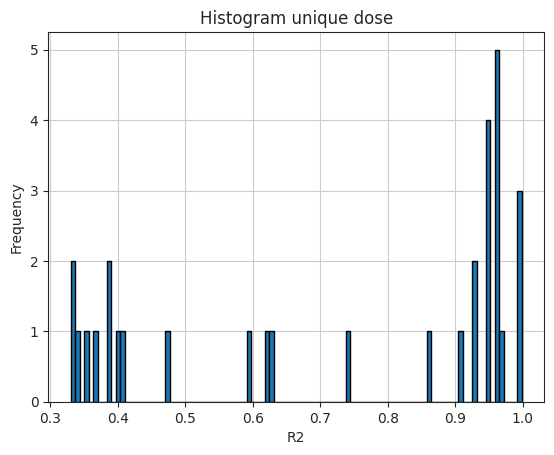

In [241]:
# Plot the histogram
plt.hist(df.iloc[0].values, bins=100, edgecolor='black')  # Adjust the number of bins as needed
plt.title('Histogram unique dose')
plt.xlabel('R2')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

## Satija's

In [3]:
adata = sc.read_h5ad('/home/icb/alejandro.tejada/merged_adata.h5ad')

In [4]:
adata

AnnData object with n_obs × n_vars = 989299 × 58347
    obs: 'orig.ident', 'nCount_originalexp', 'nFeature_originalexp', 'cell', 'sample', 'Size_Factor', 'n.umi', 'hash_umis', 'pval', 'qval', 'top_to_second_best_ratio', 'top_oligo', 'RT_well', 'Lig_well', 'P7_index', 'P5_index', 'PCR_plate', 'P5_cell', 'new_cell', 'scrublet_score', 'background_loading', 'hash_plate', 'cell_line', 'treatment', 'dose', 'replicate', 'gRNA_id', 'gene_id', 'guide_number', 'gRNA_maxCount', 'gRNA_topRatio'
    var: 'id', 'gene_short_name'

In [5]:
sc.pp.normalize_total(adata)
sc.pp.log1p(adata)

In [6]:
sc.pp.highly_variable_genes(adata, inplace=True, n_top_genes=2000)

/home/icb/alejandro.tejada/miniconda3/envs/fm/lib/python3.10/site-packages/scanpy/preprocessing/_highly_variable_genes.py:226: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  disp_grouped = df.groupby("mean_bin")["dispersions"]


In [7]:
adata

AnnData object with n_obs × n_vars = 989299 × 58347
    obs: 'orig.ident', 'nCount_originalexp', 'nFeature_originalexp', 'cell', 'sample', 'Size_Factor', 'n.umi', 'hash_umis', 'pval', 'qval', 'top_to_second_best_ratio', 'top_oligo', 'RT_well', 'Lig_well', 'P7_index', 'P5_index', 'PCR_plate', 'P5_cell', 'new_cell', 'scrublet_score', 'background_loading', 'hash_plate', 'cell_line', 'treatment', 'dose', 'replicate', 'gRNA_id', 'gene_id', 'guide_number', 'gRNA_maxCount', 'gRNA_topRatio'
    var: 'id', 'gene_short_name', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'log1p', 'hvg'

In [8]:
adata = adata[:,adata.var["highly_variable"]==True]

In [9]:
adata

View of AnnData object with n_obs × n_vars = 989299 × 2000
    obs: 'orig.ident', 'nCount_originalexp', 'nFeature_originalexp', 'cell', 'sample', 'Size_Factor', 'n.umi', 'hash_umis', 'pval', 'qval', 'top_to_second_best_ratio', 'top_oligo', 'RT_well', 'Lig_well', 'P7_index', 'P5_index', 'PCR_plate', 'P5_cell', 'new_cell', 'scrublet_score', 'background_loading', 'hash_plate', 'cell_line', 'treatment', 'dose', 'replicate', 'gRNA_id', 'gene_id', 'guide_number', 'gRNA_maxCount', 'gRNA_topRatio'
    var: 'id', 'gene_short_name', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'log1p', 'hvg'

In [11]:
adata.obs[[ 'cell_line', 'treatment', 'dose', 'replicate', 'gRNA_id', 'gene_id', 'guide_number', 'gRNA_maxCount', 'gRNA_topRatio']]

,cell_line,treatment,dose,replicate,gRNA_id,gene_id,guide_number,gRNA_maxCount,gRNA_topRatio
01A_A01_RT_BC_100_Lig_BC_134,0,1,1,0,PHKG2_4,PHKG2,1.0,502,0.896429
01A_A01_RT_BC_100_Lig_BC_253,0,4,10,0,DAPK1_2,DAPK1,1.0,467,0.917485
01A_A01_RT_BC_100_Lig_BC_26,0,0,10,0,MYO3B_3,MYO3B,1.0,784,0.894977
01A_A01_RT_BC_100_Lig_BC_340,0,0,10,0,CDK9_3,CDK9,1.0,275,0.867508
01A_A01_RT_BC_100_Lig_BC_83,0,0,10,0,NEK9_2,NEK9,1.0,482,0.894249
...,...,...,...,...,...,...,...,...,...
12D_H12_RT_BC_99_Lig_BC_147,2,1,10,0,PTK6_1,PTK6,1.0,2766,0.928811
12D_H12_RT_BC_99_Lig_BC_303,2,0,10,0,ARAF_4,ARAF,1.0,822,0.916388
12D_H12_RT_BC_99_Lig_BC_307,2,1,1,0,ERN2_3,ERN2,1.0,1,1.000000
12D_H12_RT_BC_99_Lig_BC_34,2,1,10,0,CDK9_2,CDK9,1.0,388,0.919431


In [209]:
adata.obs["perturbation"] = adata.obs["condition"]
adata.obs["cell_line"] = adata.obs["cell_type"]

/tmp/ipykernel_1021055/41560897.py:1: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs["perturbation"] = adata.obs["condition"]


In [211]:
adata_control = adata[adata.obs.perturbation == 'control+control']
adata_perturbed = adata[adata.obs.perturbation != 'control+control']

In [212]:
adata_control

View of AnnData object with n_obs × n_vars = 1451 × 2000
    obs: 'sample', 'Size_Factor', 'n.umi', 'RT_well', 'Drug1', 'Drug2', 'Well', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'leiden', 'condition', 'pathway1', 'pathway2', 'split', 'control', 'cell_type', 'perturbation', 'cell_line'
    var: 'id', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'Drug1_colors', 'Drug2_colors', 'Well_colors', 'condition_colors', 'dendrogram_leiden', 'hvg', 'leiden', 'leiden_colors', 'neighbors', 'pathway1_colors', 'pathway2_colors', 'pathway_colors', 'pca', 'rank_genes_groups', 'split_colors', 'umap', 'log1p'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'counts'
    obsp: 'connectivities', 'distances'

In [213]:
adata_control.varm["X_train_mean"] = adata_control.X.mean(axis=0).T

/tmp/ipykernel_1021055/3585228133.py:1: ImplicitModificationWarning: Setting element `.varm['X_train_mean']` of view, initializing view as actual.
  adata_control.varm["X_train_mean"] = adata_control.X.mean(axis=0).T


In [214]:
from scipy.sparse import csr_matrix, vstack

train_mean = adata_control.varm["X_train_mean"].T
adata_control.layers["centered_X"] = csr_matrix(adata_control.X.A - train_mean)

In [215]:
sc.pp.pca(adata_control, layer="centered_X", zero_center=False, n_comps=50)

In [216]:
adata_control

AnnData object with n_obs × n_vars = 1451 × 2000
    obs: 'sample', 'Size_Factor', 'n.umi', 'RT_well', 'Drug1', 'Drug2', 'Well', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'leiden', 'condition', 'pathway1', 'pathway2', 'split', 'control', 'cell_type', 'perturbation', 'cell_line'
    var: 'id', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'Drug1_colors', 'Drug2_colors', 'Well_colors', 'condition_colors', 'dendrogram_leiden', 'hvg', 'leiden', 'leiden_colors', 'neighbors', 'pathway1_colors', 'pathway2_colors', 'pathway_colors', 'pca', 'rank_genes_groups', 'split_colors', 'umap', 'log1p'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs', 'X_train_mean'
    layers: 'counts', 'centered_X'
    obsp: 'connectivities', 'distances'

In [217]:
decoded_control = np.matmul(adata_control.obsm["X_pca"], adata_control.varm["PCs"].T)

In [218]:
decoded_control.shape

(1451, 2000)

In [219]:
adata_control.varm["X_train_mean"].T.shape

(1, 2000)

In [220]:
decoded_control = decoded_control + adata_control.varm["X_train_mean"].T

In [221]:
decoded_control.shape

(1451, 2000)

In [222]:
adata_control.layers["decoded"] = decoded_control

In [223]:
adata_perturbed.varm["X_train_mean"] = adata_control.varm["X_train_mean"]

/tmp/ipykernel_1021055/3129674469.py:1: ImplicitModificationWarning: Setting element `.varm['X_train_mean']` of view, initializing view as actual.
  adata_perturbed.varm["X_train_mean"] = adata_control.varm["X_train_mean"]


In [224]:
adata_perturbed.layers["centered_X"] = csr_matrix(adata_perturbed.X.A - train_mean)


In [225]:
adata_perturbed.obsm["X_pca"] = np.matmul(adata_perturbed.layers["centered_X"].A, adata_control.varm["PCs"])


In [226]:
decoded_perturbed = np.matmul(adata_perturbed.obsm["X_pca"], adata_control.varm["PCs"].T)

In [227]:
decoded_perturbed

array([[-0.07000489,  0.04507792, -0.57818966, ...,  0.        ,
         0.0064722 ,  0.        ],
       [-0.06357426, -0.03105273, -0.28592279, ...,  0.        ,
         0.00058535,  0.        ],
       [-0.1433932 , -0.00365249, -0.40443147, ...,  0.        ,
         0.0054383 ,  0.        ],
       ...,
       [-0.00158478,  0.04010468, -0.03574026, ...,  0.        ,
         0.01117865,  0.        ],
       [-0.00099264, -0.02552648,  0.24073236, ...,  0.        ,
        -0.00328933,  0.        ],
       [-0.03212178, -0.00821749, -0.19500846, ...,  0.        ,
         0.00317082,  0.        ]])

In [228]:
decoded_perturbed = decoded_perturbed + adata_perturbed.varm["X_train_mean"].T

In [229]:
decoded_perturbed

matrix([[ 0.03510217,  0.07441067, -0.13535424, ...,  0.        ,
          0.00711592,  0.        ],
        [ 0.0415328 , -0.00171999,  0.15691263, ...,  0.        ,
          0.00122907,  0.        ],
        [-0.03828614,  0.02568025,  0.03840395, ...,  0.        ,
          0.00608202,  0.        ],
        ...,
        [ 0.10352228,  0.06943743,  0.40709516, ...,  0.        ,
          0.01182236,  0.        ],
        [ 0.10411442,  0.00380627,  0.68356778, ...,  0.        ,
         -0.00264561,  0.        ],
        [ 0.07298528,  0.02111526,  0.24782696, ...,  0.        ,
          0.00381454,  0.        ]])

In [230]:
decoded_perturbed.shape

(61927, 2000)

In [231]:
adata_perturbed.layers["decoded"] = decoded_perturbed

In [235]:
unique_doses = ["max_dose"]
unique_perturbations = adata_perturbed.obs["condition"].unique()

df = pd.DataFrame(index=unique_doses, columns=unique_perturbations)


In [236]:
reference_control = np.mean(np.asarray(decoded_control), axis=0)

In [237]:
reference_control.shape

(2000,)

In [238]:
for perturbation in tqdm(unique_perturbations):
    adata_temporal = adata_perturbed[(adata_perturbed.obs.perturbation == perturbation)]
    decoded = adata_temporal.layers["decoded"]
    decoded_mean = np.mean(np.asarray(decoded), axis=0)
    r2score_temporal = r2_score(decoded_mean, reference_control)
    df.loc["max_dose", perturbation] = r2score_temporal



100%|██████████| 31/31 [00:01<00:00, 19.52it/s]


In [239]:
df

,control+Panobinostat,Cediranib+PCI-34051,Givinostat+SRT1720,Panobinostat+SRT3025,Panobinostat+PCI-34051,control+Dacinostat,Dacinostat+PCI-34051,Panobinostat+Sorafenib,Givinostat+Cediranib,control+Givinostat,...,control+Alvespimycin,Panobinostat+Curcumin,Givinostat+Dasatinib,SRT2104+Alvespimycin,Dacinostat+Dasatinib,control+SRT2104,Givinostat+Curcumin,Givinostat+Crizotinib,SRT3025+Cediranib,control+Dasatinib
max_dose,0.402184,0.997354,0.962293,0.330006,0.388579,0.738828,0.61907,0.3525,0.961331,0.961492,...,0.931223,0.365691,0.960862,0.948157,0.595102,0.998055,0.964563,0.951202,0.998669,0.94783


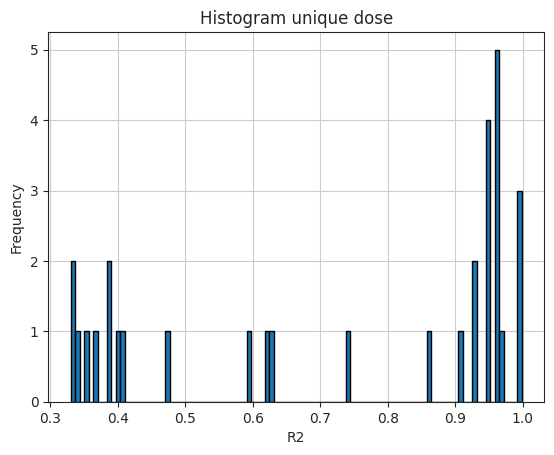

In [241]:
# Plot the histogram
plt.hist(df.iloc[0].values, bins=100, edgecolor='black')  # Adjust the number of bins as needed
plt.title('Histogram unique dose')
plt.xlabel('R2')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()